In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple
import random
import copy
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, f1_score
import time
import os
from ucimlrepo import fetch_ucirepo 

# MLP class

In [21]:
class MLP:
    def __init__(self, layer_sizes, act_fun='sigmoid', out_act_fun_name='linear', loss_fun_name='mse', metric='mse'):
        self.layer_sizes = layer_sizes
        self.n_layers = len(layer_sizes)
        self.set_act_fun(act_fun)
        self.set_out_act_fun(out_act_fun_name)
        self.set_loss_fun(loss_fun_name)
        self.metric = metric
        
        self.weights = [None] * (self.n_layers - 1)
        self.biases = [None] * (self.n_layers - 1)
        self.initialize_weights()
        
        self.total_params = self._calculate_total_params()

    def initialize_weights(self):
        for i in range(self.n_layers - 1):
            self.weights[i] = np.random.randn(self.layer_sizes[i], self.layer_sizes[i + 1]) * 0.1
            self.biases[i] = np.random.randn(self.layer_sizes[i + 1], 1) * 0.1

    def _calculate_total_params(self):
        total = 0
        for i in range(self.n_layers - 1):
            total += self.layer_sizes[i] * self.layer_sizes[i + 1]
            total += self.layer_sizes[i + 1]
        return total

    def weights_vector_to_matrices(self, weights_vector):
        """Convert flat weight vector to weight matrices and bias vectors"""
        weights = []
        biases = []
        idx = 0
        
        for i in range(self.n_layers - 1):
            # Extract weight matrix
            w_size = self.layer_sizes[i] * self.layer_sizes[i + 1]
            w_flat = weights_vector[idx:idx + w_size]
            w_matrix = w_flat.reshape(self.layer_sizes[i], self.layer_sizes[i + 1])
            weights.append(w_matrix)
            idx += w_size
            
            # Extract bias vector
            b_size = self.layer_sizes[i + 1]
            b_vector = weights_vector[idx:idx + b_size].reshape(-1, 1)
            biases.append(b_vector)
            idx += b_size
        
        return weights, biases

    def _forward(self, X, weights_vector=None, return_activations=False, return_probabilities=True):
        X = np.atleast_2d(X)
        if X.shape[0] == 1:
            X = X.reshape(-1, 1)
        
        # Use provided weights or current weights
        if weights_vector is not None:
            weights, biases = self.weights_vector_to_matrices(weights_vector)
        else:
            weights, biases = self.weights, self.biases
        
        Y = X
        if return_activations: 
            A = []

        for i in range(self.n_layers - 2):
            Y = np.dot(Y, weights[i]) + biases[i].T
            if return_activations:
                A.append(Y)
            Y = self.act_fun(Y)
            
        Y = np.dot(Y, weights[-1]) + biases[-1].T
        if return_activations:
            A.append(Y)
        Y = self.out_act_fun(Y)
        
        if not return_probabilities and self.out_act_fun_name == 'softmax':
            Y = np.argmax(Y, axis=1)
            
        return Y if not return_activations else (Y, A)

    def predict(self, X, weights_vector=None, return_probabilities=True):
        """Make predictions with optional weight vector"""
        return self._forward(X, weights_vector=weights_vector, return_probabilities=return_probabilities)

    def set_act_fun(self, act_fun):
        if act_fun == 'sigmoid':
            self.act_fun = lambda x: 1 / (1 + np.exp(-np.clip(x, -500, 500)))
            self.act_fun_prime = lambda x: np.exp(-x) / (1 + np.exp(-x)) ** 2
        elif act_fun == 'relu':
            self.act_fun = lambda x: np.maximum(0, x)
            self.act_fun_prime = lambda x: np.where(x > 0, 1, 0)
        elif act_fun == 'tanh':
            self.act_fun = lambda x: np.tanh(x)
            self.act_fun_prime = lambda x: 1 - np.tanh(x) ** 2
        elif act_fun == 'linear':
            self.act_fun = lambda x: x
            self.act_fun_prime = lambda x: np.ones_like(x)

    def set_out_act_fun(self, out_act_fun_name):
        self.out_act_fun_name = out_act_fun_name
        if out_act_fun_name == 'linear':
            self.out_act_fun = lambda x: x
            self.out_act_fun_prime = lambda x: np.ones_like(x)
        elif out_act_fun_name == 'softmax':
            self.out_act_fun = lambda x: np.exp(x - np.max(x, axis=1, keepdims=True)) / np.sum(np.exp(x - np.max(x, axis=1, keepdims=True)), axis=1, keepdims=True)
            self.out_act_fun_prime = lambda x: np.exp(x) * (1 - np.exp(x)) / np.sum(np.exp(x), axis=1, keepdims=True) ** 2
        elif out_act_fun_name == 'sigmoid':
            self.out_act_fun = lambda x: 1 / (1 + np.exp(-np.clip(x, -500, 500)))
            self.out_act_fun_prime = lambda x: np.exp(-x) / (1 + np.exp(-x)) ** 2

    def set_loss_fun(self, loss_fun_name):
        self.loss_fun_name = loss_fun_name
        def _mse(y, y_pred):
            y = np.atleast_2d(y)
            y_pred = np.atleast_2d(y_pred)
            if y.shape[0] == 1:
                y = y.reshape(-1, 1)
            if y_pred.shape[0] == 1:
                y_pred = y_pred.reshape(-1, 1)
            return np.mean((y - y_pred) ** 2)
        
        def _cross_entropy(y, y_pred):
            y = np.atleast_2d(y)
            y_pred = np.atleast_2d(y_pred)
            if y.shape[0] == 1:
                y = y.reshape(-1, 1)
            if y_pred.shape[0] == 1:
                y_pred = y_pred.reshape(-1, 1)
            return -np.mean(np.sum(y * np.log(y_pred + 1e-15), axis=1))
        
        if loss_fun_name == 'mse':
            self.loss_fun = lambda y, y_pred: _mse(y, y_pred)
        elif loss_fun_name == 'cross_entropy':
            self.loss_fun = lambda y, y_pred: _cross_entropy(y, y_pred)

# GA for MLP Training

In [22]:
class MLPGeneticAlgorithm:
    """Genetic Algorithm for training MLP neural networks"""
    
    def __init__(self, mlp: MLP, X_train: np.ndarray, y_train: np.ndarray,
                 X_test: np.ndarray = None, y_test: np.ndarray = None,
                 population_size: int = 100, max_generations: int = 1000,
                 mutation_rate: float = 0.1, crossover_rate: float = 0.8,
                 problem_type: str = 'classification'):
        """
        Initialize GA for MLP training
        """
        self.mlp = mlp
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.population_size = population_size
        self.max_generations = max_generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.problem_type = problem_type
        
        # GA state
        self.population = []
        self.best_individual = None
        self.best_fitness = float('inf')
        self.fitness_history = []
        self.test_history = []
        
        self.weight_bound = 2.0
        
    
    def create_random_individual(self):
        return np.random.uniform(-self.weight_bound, self.weight_bound, self.mlp.total_params)
    
    def calculate_fitness(self, individual):
        predictions = self.mlp.predict(self.X_train, weights_vector=individual)
        loss = self.mlp.loss_fun(self.y_train, predictions)
        return loss
    
    def tournament_selection(self, tournament_size):
        tournament_indices = np.random.choice(self.population_size, tournament_size, replace=False)
        tournament_fitness = [self.calculate_fitness(self.population[i]) for i in tournament_indices]
        best_idx = tournament_indices[np.argmin(tournament_fitness)]  # Minimize error
        return self.population[best_idx].copy()
    
    def crossover(self, parent1, parent2):
        """crossover - weighted average of parents"""
        if random.random() > self.crossover_rate:
            return parent1.copy(), parent2.copy()
        
        alpha = np.random.random()
        child1 = alpha * parent1 + (1 - alpha) * parent2
        child2 = (1 - alpha) * parent1 + alpha * parent2
        
        return child1, child2
        
    def mutate(self, individual):
        """Gaussian mutation"""
        if random.random() > self.mutation_rate:
            return individual
        
        individual = individual.copy()
        mutation_strength = 0.1
        noise = np.random.normal(0, mutation_strength, len(individual))
        individual += noise
        
        individual = np.clip(individual, -self.weight_bound, self.weight_bound)
        
        return individual

    
    def evaluate_test_performance(self, individual):
        """Evaluate performance on test set"""
        if self.X_test is None or self.y_test is None:
            return 0.0
        
        try:
            predictions = self.mlp.predict(self.X_test, weights_vector=individual, return_probabilities=False)
            
            if self.problem_type == 'classification':
                return accuracy_score(self.y_test, predictions)
            else:  # Regression
                predictions_prob = self.mlp.predict(self.X_test, weights_vector=individual, return_probabilities=True)
                return mean_squared_error(self.y_test, predictions_prob)
        except:
            return 0.0 if self.problem_type == 'classification' else float('inf')
    
    def evolve(self) -> Tuple[np.ndarray, float]:
        """Main evolution loop"""
        start_time = time.time()
        
        print("Initializing population...")
        self.population = [self.create_random_individual() for _ in range(self.population_size)]
        
        for generation in range(self.max_generations):
            fitness_scores = [self.calculate_fitness(individual) for individual in self.population]
            
            best_idx = np.argmin(fitness_scores)  
            if fitness_scores[best_idx] < self.best_fitness:
                self.best_fitness = fitness_scores[best_idx]
                self.best_individual = self.population[best_idx].copy()
            
            self.fitness_history.append(self.best_fitness)
            
            test_performance = self.evaluate_test_performance(self.best_individual)
            self.test_history.append(test_performance)
            
            if generation % 50 == 0:
                avg_fitness = np.mean(fitness_scores)
                elapsed = time.time() - start_time
                
                if self.problem_type == 'classification':
                    print(f"Gen {generation:3d}: Best Loss={self.best_fitness:.4f}, "
                          f"Avg Loss={avg_fitness:.4f}, Test Acc={test_performance:.3f}, "
                          f"Time={elapsed:.1f}s")
                else:
                    print(f"Gen {generation:3d}: Best MSE={self.best_fitness:.4f}, "
                          f"Avg MSE={avg_fitness:.4f}, Test MSE={test_performance:.4f}, "
                          f"Time={elapsed:.1f}s")
            
            new_population = []
            
            new_population.append(self.best_individual.copy())
            
            while len(new_population) < self.population_size:
                parent1 = self.tournament_selection(10)
                parent2 = self.tournament_selection(10)
                
                child1, child2 = self.crossover(parent1, parent2)
                
                child1 = self.mutate(child1)
                child2 = self.mutate(child2)
                
                new_population.extend([child1, child2])
            
            self.population = new_population[:self.population_size]
        
        total_time = time.time() - start_time
        print(f"\nEvolution completed in {total_time:.2f} seconds")
        print(f"Final best fitness: {self.best_fitness:.6f}")
        
        return self.best_individual, self.best_fitness

## Data Preparation and Testing Functions

In [23]:
def normalize(data, min_val=None, max_val=None):
    """Normalize data to [0, 1] range"""
    data = np.array(data)
    if min_val is None:
        min_val = np.min(data, axis=0)
    if max_val is None:
        max_val = np.max(data, axis=0)
    
    # Avoid division by zero
    range_val = max_val - min_val
    range_val[range_val == 0] = 1
    
    return (data - min_val) / range_val, min_val, max_val

def prepare_iris_data():
    iris = load_iris()
    X, y = iris.data, iris.target
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    X_train_norm, X_min, X_max = normalize(X_train)
    X_test_norm, _, _ = normalize(X_test, X_min, X_max)
    
    n_classes = len(np.unique(y))
    y_train_onehot = np.eye(n_classes)[y_train]
    y_test_onehot = np.eye(n_classes)[y_test]
    
    return X_train_norm, X_test_norm, y_train_onehot, y_test_onehot, y_train, y_test

def prepare_multimodal_large_data():
    X_train = pd.read_csv('../NN/data/regression/multimodal-large-training.csv')['x'].values
    y_train = pd.read_csv('../NN/data/regression/multimodal-large-training.csv')['y'].values
    X_test = pd.read_csv('../NN/data/regression/multimodal-large-test.csv')['x'].values
    y_test = pd.read_csv('../NN/data/regression/multimodal-large-test.csv')['y'].values
    
    # Reshape to proper format
    X_train = X_train.reshape(-1, 1)
    X_test = X_test.reshape(-1, 1)
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    
    # Normalize
    X_train_norm, X_min, X_max = normalize(X_train)
    X_test_norm, _, _ = normalize(X_test, X_min, X_max)
    y_train_norm, y_min, y_max = normalize(y_train)
    y_test_norm, _, _ = normalize(y_test, y_min, y_max)
    
    return X_train_norm, X_test_norm, y_train_norm, y_test_norm, y_train, y_test

def download_auto_mpg_data():
    # fetch dataset 
    auto_mpg = fetch_ucirepo(id=9) 
    
    # data (as pandas dataframes) 
    X = auto_mpg.data.features 
    y = auto_mpg.data.targets     
    
    # Combine features and targets into a single DataFrame
    df = pd.concat([X, y], axis=1)
    
    # Remove rows with missing values
    df = df.dropna()
    
    # Remove car_name column if it exists
    if 'car_name' in df.columns:
        df = df.drop('car_name', axis=1)
    
    # Split features and target
    X = df.drop('mpg', axis=1).values
    y = df['mpg'].values.reshape(-1, 1)
    
    return X, y

def prepare_auto_mpg_data():
    """Prepare Auto-MPG dataset for regression"""
    X, y = download_auto_mpg_data()
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Normalize
    X_train_norm, X_min, X_max = normalize(X_train)
    X_test_norm, _, _ = normalize(X_test, X_min, X_max)
    y_train_norm, y_min, y_max = normalize(y_train)
    y_test_norm, _, _ = normalize(y_test, y_min, y_max)
    
    return X_train_norm, X_test_norm, y_train_norm, y_test_norm, y_train, y_test

def plot_training_history(ga: MLPGeneticAlgorithm, title: str = "Training History"):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot fitness history
    ax1.plot(ga.fitness_history)
    ax1.set_title('Training Loss Evolution')
    ax1.set_xlabel('Generation')
    ax1.set_ylabel('Loss')
    ax1.grid(True, alpha=0.3)
    
    # Plot test performance history
    if ga.test_history:
        ax2.plot(ga.test_history)
        if ga.problem_type == 'classification':
            ax2.set_title('Test Accuracy Evolution')
            ax2.set_ylabel('Accuracy')
        else:
            ax2.set_title('Test MSE Evolution')
            ax2.set_ylabel('MSE')
        ax2.set_xlabel('Generation')
        ax2.grid(True, alpha=0.3)
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def plot_regression_results(X_test, y_test, predictions, title="Regression Results"):
    """Plot regression results"""
    plt.figure(figsize=(10, 6))
    plt.scatter(X_test.flatten(), y_test.flatten(), alpha=0.6, label='True values')
    plt.scatter(X_test.flatten(), predictions.flatten(), alpha=0.6, label='Predictions')
    plt.xlabel('Input')
    plt.ylabel('Output')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

## Test 1: Iris Classification Dataset

TEST 1: IRIS CLASSIFICATION DATASET
Training samples: 105
Test samples: 45
Features: 4
Classes: 3
MLP Architecture: [4, 8, 6, 3]
Total parameters: 115
Initializing population...
Gen   0: Best Loss=1.1152, Avg Loss=1.8997, Test Acc=0.400, Time=0.0s
Gen  50: Best Loss=0.6952, Avg Loss=0.7076, Test Acc=0.711, Time=6.6s
Gen 100: Best Loss=0.5073, Avg Loss=0.5139, Test Acc=0.867, Time=11.9s
Gen 150: Best Loss=0.3766, Avg Loss=0.3823, Test Acc=0.956, Time=16.3s
Gen 200: Best Loss=0.3264, Avg Loss=0.3290, Test Acc=0.956, Time=20.7s
Gen 250: Best Loss=0.2980, Avg Loss=0.3005, Test Acc=0.956, Time=25.2s

Evolution completed in 29.62 seconds
Final best fitness: 0.260778

Final Results:
Training Accuracy: 0.9238
Test Accuracy: 0.9556
Final Training Loss: 0.260778


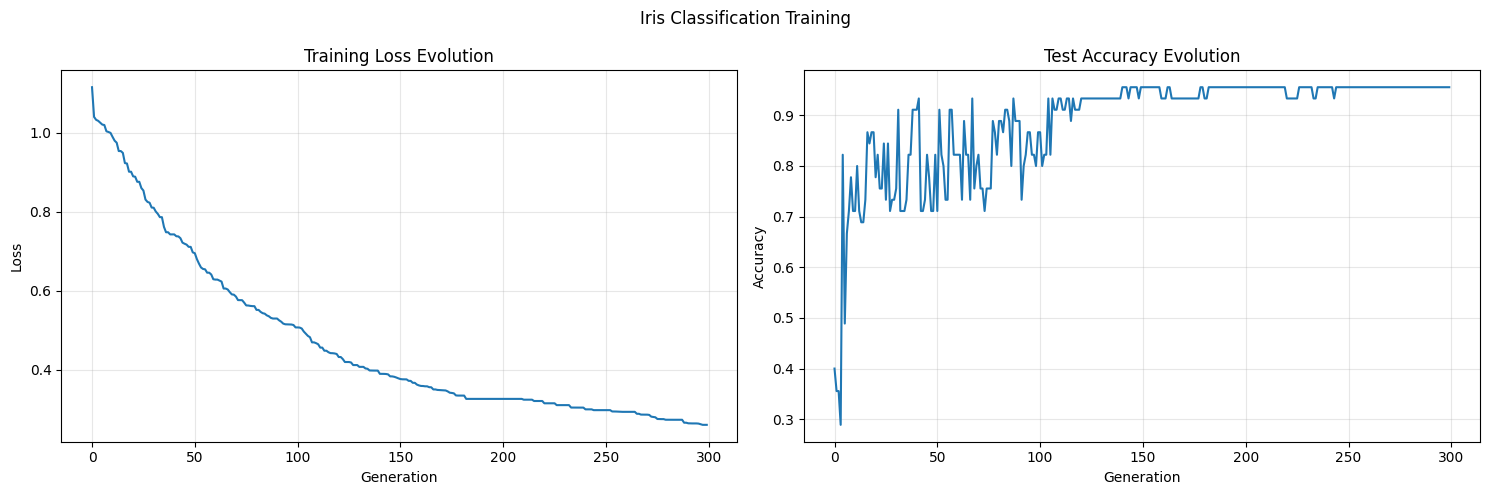

In [24]:
print("="*60)
print("TEST 1: IRIS CLASSIFICATION DATASET")
print("="*60)

# Prepare Iris data
X_train, X_test, y_train_onehot, y_test_onehot, y_train, y_test = prepare_iris_data()

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Features: {X_train.shape[1]}")
print(f"Classes: {y_train_onehot.shape[1]}")

# Create MLP for Iris classification
mlp_iris = MLP(
    layer_sizes=[4, 8, 6, 3],
    act_fun='sigmoid',
    out_act_fun_name='softmax',
    loss_fun_name='cross_entropy',
    metric='f1'
)

print(f"MLP Architecture: {mlp_iris.layer_sizes}")
print(f"Total parameters: {mlp_iris.total_params}")

# Train with GA
ga_iris = MLPGeneticAlgorithm(
    mlp=mlp_iris,
    X_train=X_train,
    y_train=y_train_onehot,
    X_test=X_test,
    y_test=y_test,  # Use original labels for accuracy calculation
    population_size=80,
    max_generations=300,
    mutation_rate=0.15,
    crossover_rate=0.8,
    problem_type='classification'
)

best_weights_iris, best_fitness_iris = ga_iris.evolve()

# Final evaluation
train_predictions = mlp_iris.predict(X_train, weights_vector=best_weights_iris, return_probabilities=False)
test_predictions = mlp_iris.predict(X_test, weights_vector=best_weights_iris, return_probabilities=False)

train_acc = accuracy_score(y_train, train_predictions)
test_acc = accuracy_score(y_test, test_predictions)

print(f"\nFinal Results:")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Final Training Loss: {best_fitness_iris:.6f}")

# Plot training history
plot_training_history(ga_iris, "Iris Classification Training")

TEST 2: MULTIMODAL-LARGE REGRESSION DATASET
Training samples: 10000
Test samples: 1000
Features: 1
MLP Architecture: [1, 10, 10, 1]
Total parameters: 141
Initializing population...
Gen   0: Best MSE=0.1251, Avg MSE=5.5319, Test MSE=0.1262, Time=0.3s
Gen  50: Best MSE=0.1076, Avg MSE=0.1101, Test MSE=0.1084, Time=161.3s
Gen 100: Best MSE=0.0988, Avg MSE=0.1024, Test MSE=0.0995, Time=328.5s
Gen 150: Best MSE=0.0892, Avg MSE=0.0999, Test MSE=0.0896, Time=499.6s
Gen 200: Best MSE=0.0891, Avg MSE=0.0990, Test MSE=0.0895, Time=675.9s
Gen 250: Best MSE=0.0876, Avg MSE=0.0950, Test MSE=0.0879, Time=831.9s
Gen 300: Best MSE=0.0816, Avg MSE=0.0954, Test MSE=0.0816, Time=1003.0s
Gen 350: Best MSE=0.0793, Avg MSE=0.0933, Test MSE=0.0792, Time=1170.2s
Gen 400: Best MSE=0.0791, Avg MSE=0.0937, Test MSE=0.0790, Time=1336.3s
Gen 450: Best MSE=0.0791, Avg MSE=0.0840, Test MSE=0.0790, Time=1498.9s

Evolution completed in 1676.18 seconds
Final best fitness: 0.076575

Final Results:
Training MSE: 0.076575

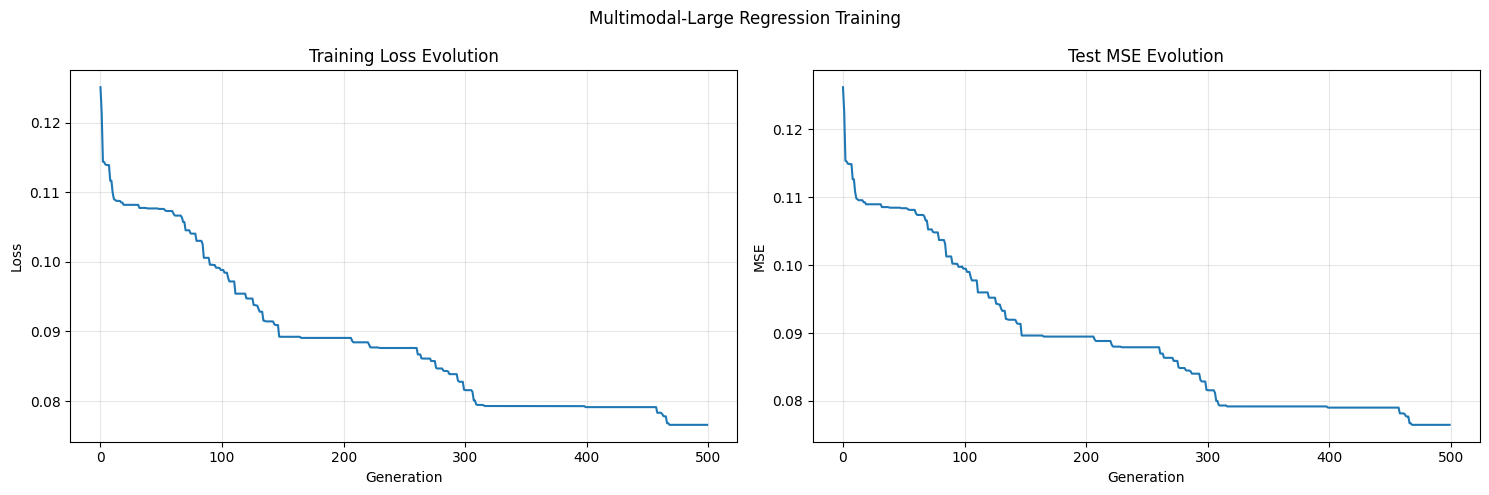

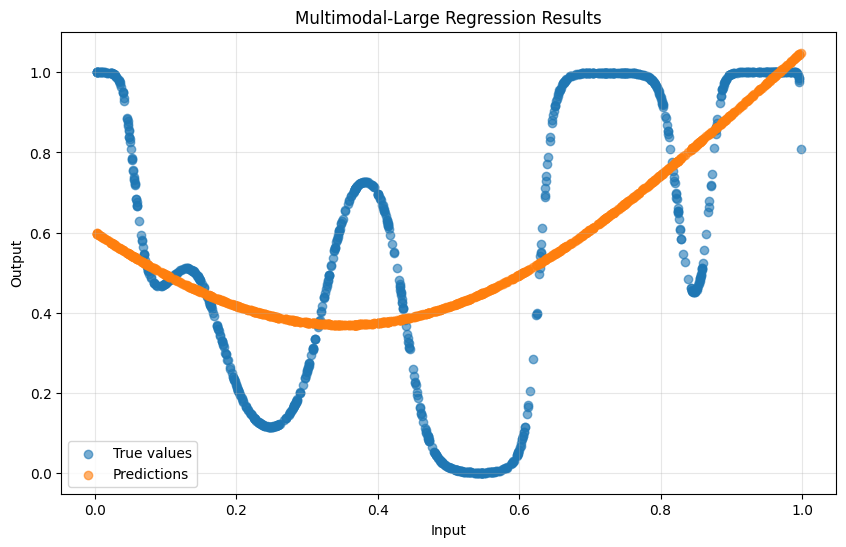

In [33]:
print("="*60)
print("TEST 2: MULTIMODAL-LARGE REGRESSION DATASET")
print("="*60)

# Prepare multimodal-large data
X_train, X_test, y_train, y_test, y_train_orig, y_test_orig = prepare_multimodal_large_data()

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Features: {X_train.shape[1]}")

# Create MLP for multimodal regression
mlp_multimodal = MLP(
    layer_sizes=[1, 10, 10, 1],
    act_fun='sigmoid',
    out_act_fun_name='linear',
    loss_fun_name='mse',
    metric='mse'
)

print(f"MLP Architecture: {mlp_multimodal.layer_sizes}")
print(f"Total parameters: {mlp_multimodal.total_params}")

# Train with GA
ga_multimodal = MLPGeneticAlgorithm(
    mlp=mlp_multimodal,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    population_size=100,
    max_generations=500,
    mutation_rate=0.15,
    crossover_rate=0.8,
    problem_type='regression'
)

best_weights_multimodal, best_fitness_multimodal = ga_multimodal.evolve()

# Final evaluation
train_predictions = mlp_multimodal.predict(X_train, weights_vector=best_weights_multimodal)
test_predictions = mlp_multimodal.predict(X_test, weights_vector=best_weights_multimodal)

train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

print(f"\nFinal Results:")
print(f"Training MSE: {train_mse:.6f}")
print(f"Test MSE: {test_mse:.6f}")
print(f"Final Training Loss: {best_fitness_multimodal:.6f}")

# Plot training history and results
plot_training_history(ga_multimodal, "Multimodal-Large Regression Training")

# Sort by X for better visualization
sort_idx = np.argsort(X_test.flatten())
plot_regression_results(X_test[sort_idx], y_test[sort_idx], test_predictions[sort_idx], 
                       "Multimodal-Large Regression Results")

TEST 3: AUTO-MPG REGRESSION DATASET
Training samples: 274
Test samples: 118
Features: 7
MLP Architecture: [7, 15, 10, 5, 1]
Total parameters: 341
Initializing population...
Gen   0: Best MSE=0.0313, Avg MSE=3.3826, Test MSE=0.0239, Time=0.0s
Gen  50: Best MSE=0.0118, Avg MSE=0.0171, Test MSE=0.0102, Time=6.7s
Gen 100: Best MSE=0.0097, Avg MSE=0.0116, Test MSE=0.0091, Time=13.6s
Gen 150: Best MSE=0.0085, Avg MSE=0.0092, Test MSE=0.0082, Time=20.7s
Gen 200: Best MSE=0.0081, Avg MSE=0.0102, Test MSE=0.0074, Time=27.4s
Gen 250: Best MSE=0.0068, Avg MSE=0.0124, Test MSE=0.0059, Time=34.1s

Evolution completed in 40.99 seconds
Final best fitness: 0.006547

Final Results:
Training MSE: 0.006547
Test MSE: 0.005503
Final Training Loss: 0.006547


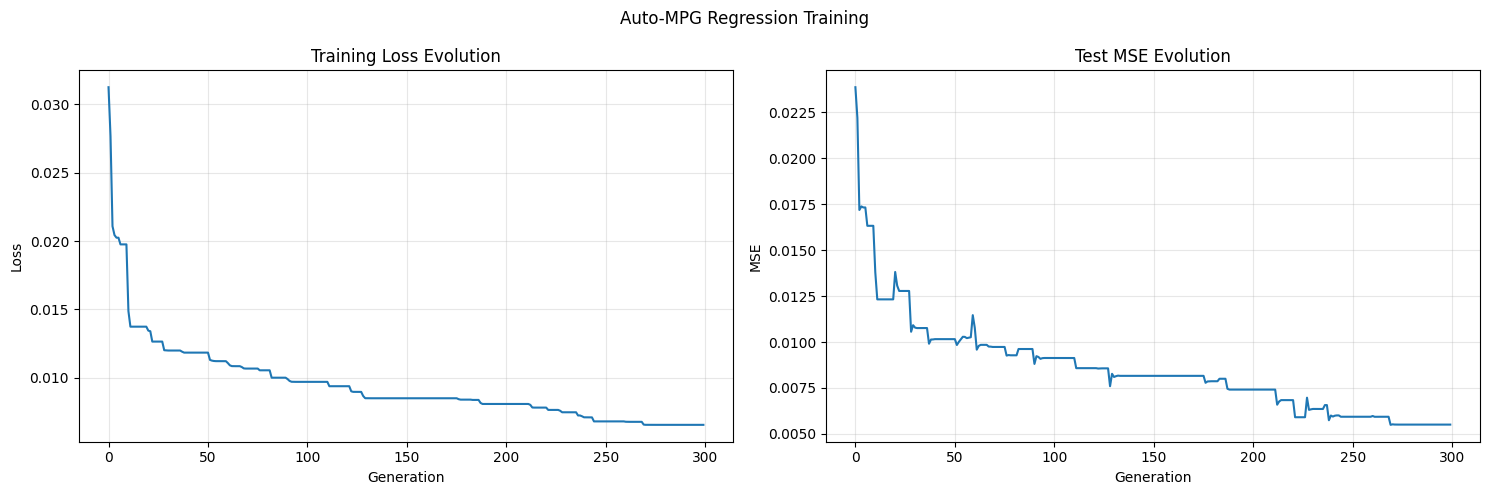

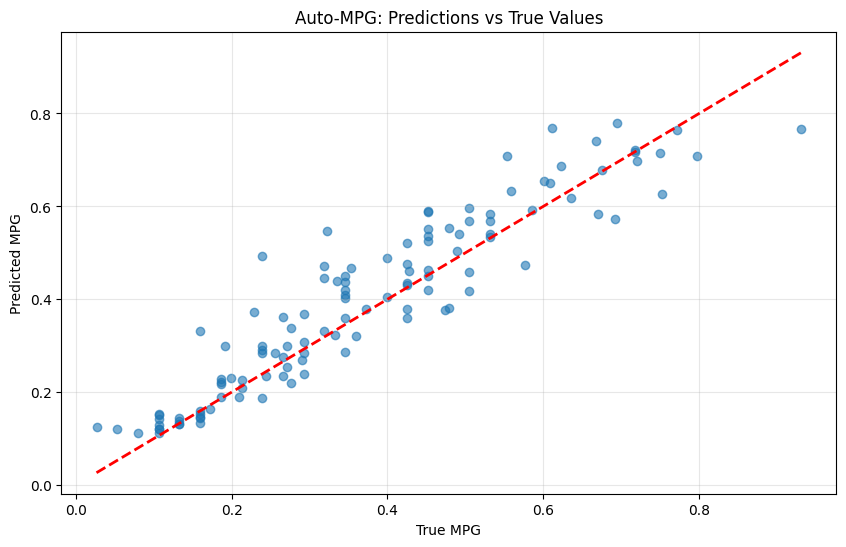

In [34]:
print("="*60)
print("TEST 3: AUTO-MPG REGRESSION DATASET")
print("="*60)

# Prepare Auto-MPG data
X_train, X_test, y_train, y_test, y_train_orig, y_test_orig = prepare_auto_mpg_data()

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Features: {X_train.shape[1]}")

# Create MLP for Auto-MPG regression
mlp_auto = MLP(
    layer_sizes=[7, 15, 10, 5, 1],
    act_fun='sigmoid',
    out_act_fun_name='linear',
    loss_fun_name='mse',
    metric='mse'
)

print(f"MLP Architecture: {mlp_auto.layer_sizes}")
print(f"Total parameters: {mlp_auto.total_params}")

# Train with GA
ga_auto = MLPGeneticAlgorithm(
    mlp=mlp_auto,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    population_size=100,
    max_generations=300,
    mutation_rate=0.1,
    crossover_rate=0.8,
    problem_type='regression'
)

best_weights_auto, best_fitness_auto = ga_auto.evolve()

# Final evaluation
train_predictions = mlp_auto.predict(X_train, weights_vector=best_weights_auto)
test_predictions = mlp_auto.predict(X_test, weights_vector=best_weights_auto)

train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

print(f"\nFinal Results:")
print(f"Training MSE: {train_mse:.6f}")
print(f"Test MSE: {test_mse:.6f}")
print(f"Final Training Loss: {best_fitness_auto:.6f}")

# Plot training history
plot_training_history(ga_auto, "Auto-MPG Regression Training")

# Scatter plot of predictions vs true values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('True MPG')
plt.ylabel('Predicted MPG')
plt.title('Auto-MPG: Predictions vs True Values')
plt.grid(True, alpha=0.3)
plt.show()

## Comparison and Analysis

SUMMARY OF ALL EXPERIMENTS

1. IRIS CLASSIFICATION:
   - Training Accuracy: 0.9238
   - Test Accuracy: 0.9556
   - Final Loss: 0.260778
   - Network: [4, 8, 6, 3]
   - Parameters: 115

2. MULTIMODAL-LARGE REGRESSION:
   - Final Loss: 0.076575
   - Network: [1, 10, 10, 1]
   - Parameters: 141

3. AUTO-MPG REGRESSION:
   - Final Loss: 0.006547
   - Network: [7, 15, 10, 5, 1]
   - Parameters: 341


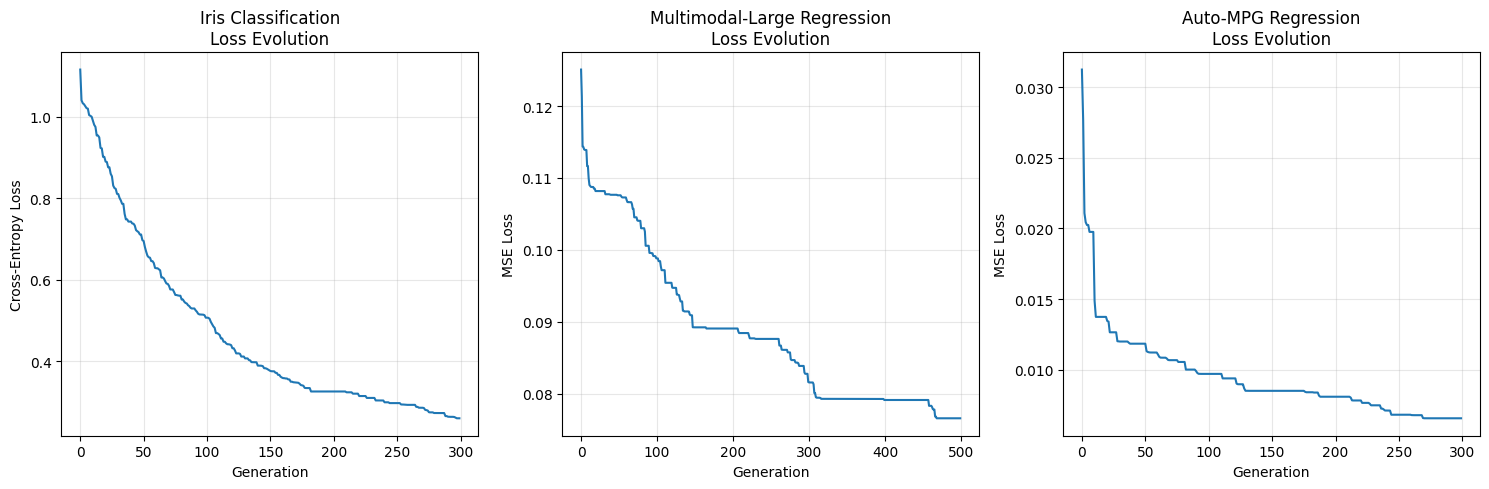

In [36]:
# Summary of results
print("="*60)
print("SUMMARY OF ALL EXPERIMENTS")
print("="*60)

print("\n1. IRIS CLASSIFICATION:")
print(f"   - Training Accuracy: {train_acc:.4f}")
print(f"   - Test Accuracy: {test_acc:.4f}")
print(f"   - Final Loss: {best_fitness_iris:.6f}")
print(f"   - Network: {mlp_iris.layer_sizes}")
print(f"   - Parameters: {mlp_iris.total_params}")

print(f"\n2. MULTIMODAL-LARGE REGRESSION:")
print(f"   - Final Loss: {best_fitness_multimodal:.6f}")
print(f"   - Network: {mlp_multimodal.layer_sizes}")
print(f"   - Parameters: {mlp_multimodal.total_params}")

# Recalculate for auto-mpg to ensure we have the values
train_mse_auto = mean_squared_error(y_train, mlp_auto.predict(X_train, weights_vector=best_weights_auto))
test_mse_auto = mean_squared_error(y_test, mlp_auto.predict(X_test, weights_vector=best_weights_auto))

print(f"\n3. AUTO-MPG REGRESSION:")
print(f"   - Final Loss: {best_fitness_auto:.6f}")
print(f"   - Network: {mlp_auto.layer_sizes}")
print(f"   - Parameters: {mlp_auto.total_params}")

# Plot all fitness histories together
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(ga_iris.fitness_history)
plt.title('Iris Classification\nLoss Evolution')
plt.xlabel('Generation')
plt.ylabel('Cross-Entropy Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(ga_multimodal.fitness_history)
plt.title('Multimodal-Large Regression\nLoss Evolution')
plt.xlabel('Generation')
plt.ylabel('MSE Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(ga_auto.fitness_history)
plt.title('Auto-MPG Regression\nLoss Evolution')
plt.xlabel('Generation')
plt.ylabel('MSE Loss')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()